In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Parameters

In [2]:
hier = False
kind = 'fix_on'

res = 5  # ms

# loosely based on region-average stim on latency
byregion_defaults = {
    'V1': 40,
    'V2': 40,
    'V4': 50,
    'PIT': 65,
    'CIT': 80,
    'AIT': 100}

In [3]:
# Parameters
hier = True


# Load catalogs

In [4]:
tag = 'hier_' if hier else ''
unit_df = pd.read_csv(f'../../db/{tag}units.csv.gz')
unit_df['Subject'] = [v[:2] for v in unit_df['Session']]

In [5]:
ar_df = pd.read_csv('../../db/bank_array_regions.csv')
ar_df['Subject'] = [v[:2] for v in ar_df['Session']]
ar_df = ar_df.groupby(['Subject', 'Array ID']).first()
unit_df['Region'] = ar_df.loc[pd.MultiIndex.from_frame(unit_df[['Subject', 'Array ID']]), 'Region'].values

In [6]:
slatdf_path = f'summary/{kind}_latency.csv.gz'
alatdf_path = slatdf_path.replace('_latency', '_latency-array_level')

assert Path(slatdf_path).is_file()
assert Path(alatdf_path).is_file()

slat_df = pd.read_csv(slatdf_path)
if hier:
    slat_df['Name'] = [f'{v0}/{v1}' for v0, v1 in slat_df[['Level', 'Name']].values]

alat_df = pd.read_csv(alatdf_path)

# Impute values

### Apply resolution for estimates

In [7]:
slat_df['Latency'] = (slat_df['Latency']/res).round().astype(int) * res
alat_df['Latency'] = (alat_df['Latency']/res).round().astype(int) * res

### Per unit, then channel, then array, within session

In [8]:
assert 'Level' in slat_df.columns
unit_df[['Latency', 'Boots. stdev.']] = np.nan
mn = np.isnan(unit_df['Latency'].values)

for level in ('Unit', 'Channel', 'Array'):
    m = slat_df['Level'] == level
    assert m.any()
    sllat_df = slat_df[m].groupby(['Session', 'Name']).agg({'Latency':'median','Boots. stdev.':np.nanmedian})
    level_col = {'Unit': 'Name', 'Array': 'Array ID'}.get(level, level)
    if hier:
        unit_index = pd.MultiIndex.from_arrays([
            unit_df['Session'],
            [f'{level}/{n}' if level!='Unit' else n for n in unit_df[level_col]]])
    else:
        unit_index = pd.MultiIndex.from_frame(
            unit_df[['Session', level_col]].astype(str))
    unit_index.names = ['Session', 'Name']
    vals = sllat_df[['Latency', 'Boots. stdev.']].reindex(unit_index).values

    msl_= np.isfinite(vals[:,0])
    msl = mn & msl_
    print(f'{msl_.mean()*100:.1f}% (n = {msl_.sum()}) of units have {level}-level latency estimates')
    print(f'\t{msl.mean()*100:.1f}% (n = {msl.sum()}) have no previous estimates')
    unit_df.loc[msl, ['Latency', 'Boots. stdev.']] = vals[msl]
    unit_df.loc[msl, 'Source'] = level

    mn = np.isnan(unit_df['Latency'].values)
    print(f'{mn.mean()*100:.1f}% (n = {mn.sum()} of units still lack an estimate')
    print()

4.1% (n = 3164) of units have Unit-level latency estimates
	4.1% (n = 3164) have no previous estimates
95.9% (n = 74257 of units still lack an estimate

7.9% (n = 6119) of units have Channel-level latency estimates
	5.4% (n = 4189) have no previous estimates
90.5% (n = 70068 of units still lack an estimate

27.7% (n = 21428) of units have Array-level latency estimates
	20.4% (n = 15759) have no previous estimates
70.1% (n = 54309 of units still lack an estimate



### Per array, across sessions

In [9]:
df_ = alat_df.set_index(['Subject', 'Name'])
assert not df_.index.has_duplicates
vals = df_[['Latency', 'Boots. stdev.']].reindex(pd.MultiIndex.from_frame(unit_df[['Subject', 'Array ID']])).values
ma = np.isfinite(vals[:,0])
m = ma & np.isnan(unit_df['Latency'].values)
unit_df.loc[m, ['Latency', 'Boots. stdev.']] = vals[m]
unit_df.loc[m, 'Source'] = 'Array, across sess'

print(f'{ma.mean()*100:.1f}% (n = {ma.sum()} of units have array-level latency estimates')
print(f'\t{m.mean()*100:.1f}% (n = {m.sum()}) have no previous estimates')

mn = np.isnan(unit_df['Latency'].values)
print(f'{mn.mean()*100:.1f}% (n = {mn.sum()} of units still lack an estimate')

81.0% (n = 62685 of units have array-level latency estimates
	51.3% (n = 39683) have no previous estimates
18.9% (n = 14626 of units still lack an estimate


### Per region (fixed default)

In [10]:
mx = np.isnan(unit_df['Latency'].values)
unit_df.loc[mx, 'Latency'] = [byregion_defaults[v] for v in unit_df.loc[mx,'Region'].values]
unit_df.loc[mx, 'Source'] = 'Region default'
print(f'{mx.mean()*100:.1f}% (n = {mx.sum()} of units used region-default estimates')

mn = np.isnan(unit_df['Latency'].values)
print(f'{mn.mean()*100:.1f}% (n = {mn.sum()} of units still lack an estimate')
assert not mn.any()

18.9% (n = 14626 of units used region-default estimates
0.0% (n = 0 of units still lack an estimate


### Save results

In [11]:
assert np.isfinite(unit_df['Latency']).all()
assert all(len(v) for v in unit_df['Source'])
df = unit_df[['Session', 'Name', 'Latency', 'Boots. stdev.', 'Source']]
df = df.astype({'Latency': int}).round({'Boots. stdev.': 1})
df.to_csv(f'../../db/per_{tag}unit_latency-{kind}.csv.gz', index=False)

In [12]:
print('Fraction of estimates from each source:')
(df.groupby(['Source']).count() / len(df) * 100).round(1)

Fraction of estimates from each source:


,Session,Name,Latency,Boots. stdev.
Source,,,,
Array,20.4,20.4,20.4,20.4
"Array, across sess",51.3,51.3,51.3,51.3
Channel,5.4,5.4,5.4,5.4
Region default,18.9,18.9,18.9,0.0
Unit,4.1,4.1,4.1,4.1


### Summary plots

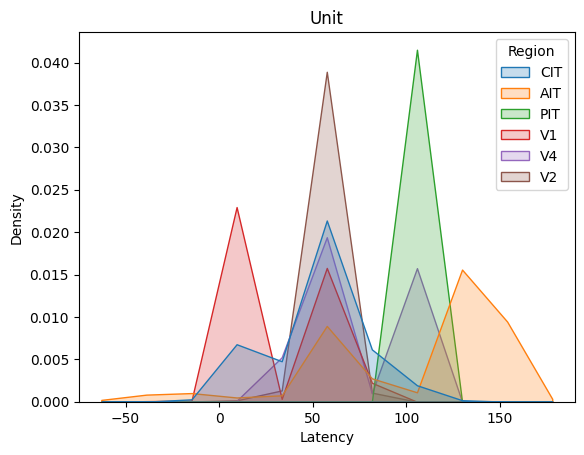

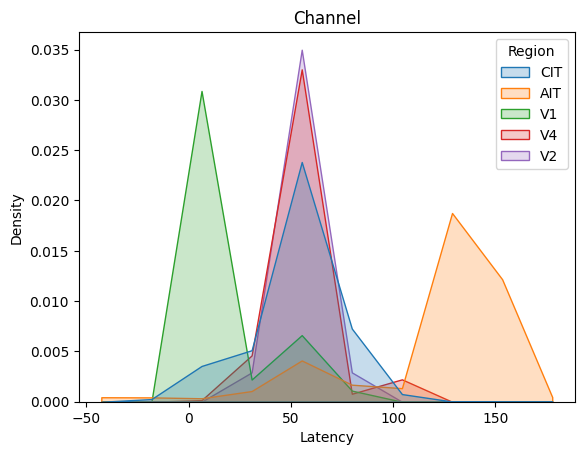

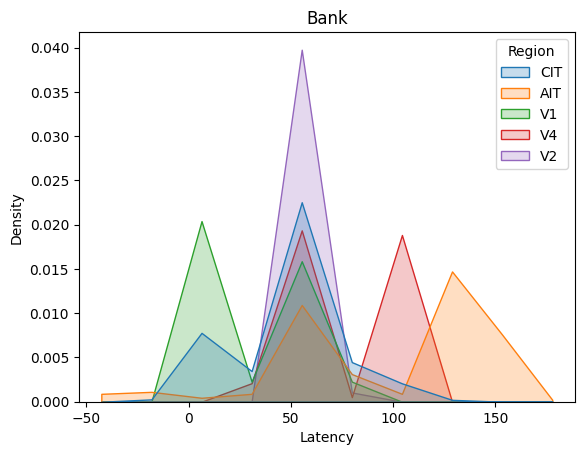

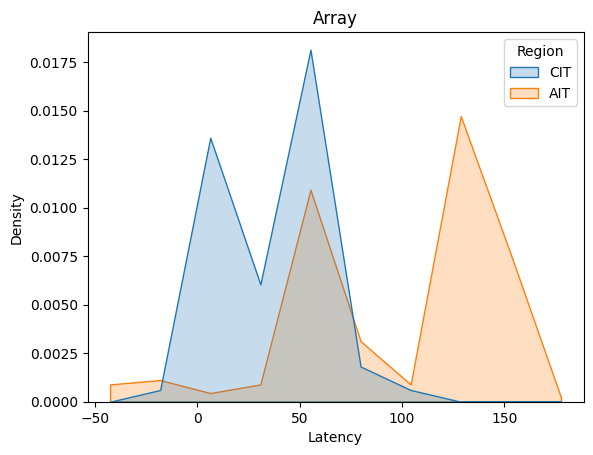

In [13]:
if hier:
    m = unit_df['Source'] != 'Region default'
    for level in unit_df['Level'].unique():
        plt.figure()
        sns.histplot(
            data=unit_df[m&(unit_df['Level']==level)],
            x='Latency', hue='Region', stat='density',
            common_norm=False, binwidth=25, element='poly')
        plt.title(level)
else:
    sns.histplot(
        data=unit_df[unit_df['Source']!='Region default'],
        x='Latency', hue='Region', stat='density',
        common_norm=False, binwidth=25, element='poly')